In [1]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep, makedirs
from os.path import isfile, join, abspath, expanduser, exists
from moviepy.editor import AudioFileClip, VideoFileClip
#from moviepy.video.io.VideoFileClip import VideoFileClip, AudioFileClip

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from ggplot import *
from datetime import timedelta
import scenedetect

Wall time: 4.88 s


# Load model, load video into a byte array, perform FFT

In [2]:
home = expanduser("~")
dirpath = join(home,"Downloads","videos")
file_basename = 'test_cry_che_1st_half_eng'
videoFileName = join(dirpath, file_basename+'.mp4')
maxClipLength = 6 # Minutes
model = joblib.load('model_gra.pkl') 
#model = joblib.load('model_knn.pkl') 
pca_model = joblib.load('model_pca.pkl') 

In [3]:
%%time
F = []
#print row['secondOffset'], row['timeToCapture']
if isfile(videoFileName):
    videoClip = VideoFileClip(videoFileName)
    fps = videoClip.fps
    audioClip = AudioFileClip(videoFileName)
    samprate = audioClip.fps
    print('Video duration: {0}, fps: {1}, audio sample rate {2}'.format(timedelta(seconds=round(audioClip.duration)), fps, samprate))
    wavClip = audioClip.to_soundarray(fps=samprate)
    wavClip = wavClip[:samprate*int(audioClip.duration),]
    wavdata = wavClip.reshape(-1, samprate,  2)
    dims = wavdata.shape
    for sec in np.arange(dims[0]):
        ch1 = scipy.fftpack.fft(wavdata[sec,:,0])[:samprate//2] # Left channel
        ch2 = scipy.fftpack.fft(wavdata[sec,:,1])[:samprate//2] # Right channel
        ch = np.vstack([ch1,ch2])
        F.append(ch)
#    del audioClip, videoClip
else:
    print('Could not find file ', videoFileName)

F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

Video duration: 0:47:37, fps: 30.3, audio sample rate 44100
Wall time: 1min 9s


# Predict each second's likelihood of being interesting

In [4]:
print(F_db.shape)
F2 = F.reshape(F_db.shape[0],-1)
print (F2.shape)

(2857, 2, 22050)
(2857, 44100)


In [5]:
%%time
index=np.array(np.arange(F2.shape[0]))
data= pca_model.transform(F2)
N=8 # Running average span
print(data.shape)

predicted_labels = model.predict(data)
predicted_proba = model.predict_proba(data)
# Calcualte running average
running_predicted_labels = pd.rolling_mean(predicted_proba[:,0]+predicted_proba[:,1], N) # 0 means "goal", 1 is "near miss". 
# Assign the value to the first second.
running_predicted_labels = np.concatenate((running_predicted_labels[N-1:,], 
                     np.array([np.average(predicted_proba[-i:,0]+predicted_proba[-i:,1]) for i in np.arange(N-1,0,-1)])))
print(predicted_proba.shape)
print(running_predicted_labels.shape)


(2857, 170)
(2857, 3)
(2857,)
Wall time: 8.99 s


In [6]:
def on_plot_hover(event):
    for curve in plot.get_lines():
        if curve.contains(event)[0]:
            print("over %s" % curve.get_gid())
            
def plotGame(i,g):
    fig = plt.figure(figsize=(15, 6))
    plot = plt.plot(i/60,g, alpha=0.5)
    fig.canvas.mpl_connect('motion_notify_event', on_plot_hover)           
    plt.xlabel('Game Minutes')
    plt.ylabel('Goal Likelihood')
    plt.show()

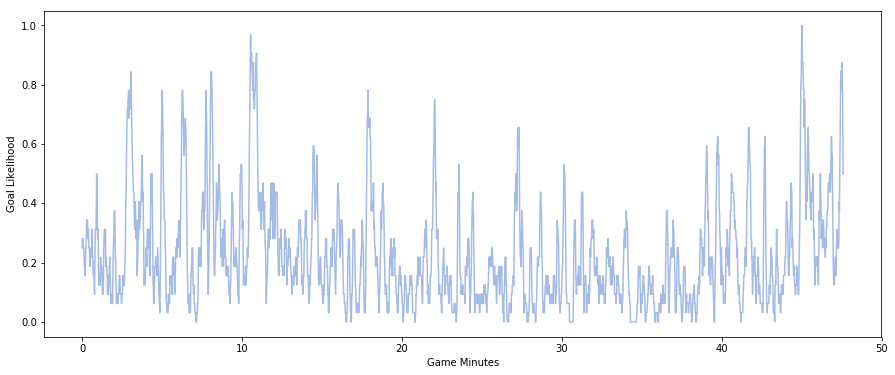

Total video length: 0:47:37


In [7]:
plotGame(index, running_predicted_labels)
print("Total video length:", timedelta(seconds=len(running_predicted_labels)))

# Determine distinct events

In [ ]:
%%time
from cv2 import ORB_create, xfeatures2d, imread

indexed_running_predicted_labels = np.argsort(running_predicted_labels)
eventsFounds = 0
events = []
gameMeanLikelihood = np.mean(running_predicted_labels)
#for idx in reversed(indexed_running_predicted_labels[:len(running_predicted_labels)-(N-1)]):
for idx in reversed(indexed_running_predicted_labels):
    found=False
    for e in events:
        if idx >= e["start"] and idx-5 <= e["end"]:
            if found == True:
                remember_e=e["end"]
                remember_s=e["start"]
                events.remove(e)
                for e2 in events:
                    if  idx >= e2["start"] and idx-5 <= e2["end"]:
                        e2["start"] = min(e2["start"],remember_s)
                        e2["end"] = max(e2["end"],remember_e)
            else:
                if idx > e["end"] and running_predicted_labels[idx] <= running_predicted_labels[e["end"]]:
                    e["end"] = idx
                found=True
        elif idx+1 == e["start"] and running_predicted_labels[idx] <= running_predicted_labels[e["start"]]:
            e["start"] = idx
            if found == True:
                remember=e["end"]
                events.remove(e)
                for e2 in events:
                    if e2["end"] == idx:
                        e2["end"] = remember
            else:
                found=True
        elif idx-1 == e["end"] and running_predicted_labels[idx] <= running_predicted_labels[e["end"]]:
            e["end"] = idx
            if found == True:
                remember=e["start"]
                events.remove(e)
                for e2 in events:
                    if e2["start"] == idx:
                        e2["start"] = remember
            else:
                found=True
    if found == False:
        eventsFounds+=1
        event={"peak" : idx, "value" : running_predicted_labels[idx],"start" : idx, "end" : idx}
        events.append(event)
    if running_predicted_labels[idx] <= gameMeanLikelihood:
        break


Wall time: 79 ms


# Extract clips of top 15 events

In [ ]:
clipDir=join(dirpath, file_basename)
if not exists(clipDir):
    makedirs(clipDir)
for idx, event in enumerate(events[:10]):
    eventClip = VideoFileClip(videoFileName).subclip(event['start'],event['end'])
    eventClip.write_videofile(join(clipDir, "scene"+str(idx)+".mp4"))
    del eventClip.reader
    del eventClip

[MoviePy] >>>> Building video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene0.mp4
[MoviePy] Writing audio in scene0TEMP_MPY_wvf_snd.mp3


100%|█████████████████████████████████████████████████████████████████████████████| 1235/1235 [00:01<00:00, 709.36it/s]


[MoviePy] Done.
[MoviePy] Writing video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene0.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 1697/1697 [01:05<00:00, 25.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene0.mp4 

[MoviePy] >>>> Building video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene1.mp4
[MoviePy] Writing audio in scene1TEMP_MPY_wvf_snd.mp3


100%|█████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:01<00:00, 739.85it/s]


[MoviePy] Done.
[MoviePy] Writing video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene1.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 1940/1940 [01:06<00:00, 29.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene1.mp4 

[MoviePy] >>>> Building video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene2.mp4
[MoviePy] Writing audio in scene2TEMP_MPY_wvf_snd.mp3


100%|███████████████████████████████████████████████████████████████████████████████| 552/552 [00:00<00:00, 641.86it/s]


[MoviePy] Done.
[MoviePy] Writing video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene2.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 758/758 [00:20<00:00, 36.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene2.mp4 

[MoviePy] >>>> Building video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene3.mp4
[MoviePy] Writing audio in scene3TEMP_MPY_wvf_snd.mp3


100%|█████████████████████████████████████████████████████████████████████████████| 1522/1522 [00:01<00:00, 761.76it/s]


[MoviePy] Done.
[MoviePy] Writing video C:\Users\Roy\Downloads\videos\test_cry_che_1st_half_eng\scene3.mp4


 94%|███████████████████████████████████████████████████████████████████████▎    | 1962/2091 [16:08<3:26:37, 96.10s/it]                                                                                                                       

# Use scene detection to pick better start/stop per event
## Cut the clip after maxClipLength minutes

In [ ]:
%%time
# Prepare parameters for scene detection        
detector_list = [
   scenedetect.detectors.ContentDetector(threshold = 30, min_scene_len = 8),
   scenedetect.detectors.ThresholdDetector(threshold = 70, min_percent = 0.9)
]        

# Prepare objects for SURF (cound number of objects in a sample frame from each scene) 
orb = ORB_create()
surf = xfeatures2d.SURF_create(hessianThreshold=10000, nOctaves=15, upright=1)
clipTotal = 0
for idx, event in enumerate(events[:10]):
#    print("Peak:",timedelta(seconds=int(event['peak'])),"Value:",event['value'],chr(9),timedelta(seconds=int(event['start'])),'-',timedelta(seconds=int(event['end'])))
#     if idx<=5: #temp for debug
#         print("Peak:",timedelta(seconds=int(event['peak'])),"Value:",event['value'],chr(9),
#           timedelta(seconds=int(event['start'])),'-',timedelta(seconds=int(event['end'])))
#         continue
    # If this clip overlaps with a previous clip - skip it
    if len([1 for i in np.arange(idx) if event['start'] < events[i]['clipEndMs']/1000 
                    and event['end'] > events[i]['clipStartMs']/1000]) > 0:
        break
    scene_list = []
    video_framerate, frames_read = scenedetect.detect_scenes_file(
                    videoFileName, scene_list, detector_list, frame_skip = 0, downscale_factor = 3, 
                    timecode_list=[round((int(events[idx]['start'])-30)*fps),round((int(events[idx]['end'])+60)*fps),-1])

    # create new list with scene boundaries in milliseconds instead of frame #.
    scene_list_msec = sorted([(1000 * x) / float(video_framerate) for x in scene_list])
    events[idx]["clipStartMs"]=int(event['start'])*1000
    events[idx]["clipEndMs"]=int(event['end'])*1000
    for sceneIdx, scene in enumerate(scene_list_msec[:-1]):
        if event['peak'] - scene/1000 > 30:
                events[idx]["clipStartMs"]=scene_list_msec[sceneIdx]
        else:
                events[idx]["clipEndMs"]=scene_list_msec[sceneIdx]
        fPath=join(dirpath,"event{:d}-frame{:d}.jpg".format(idx,sceneIdx))
        videoClip.save_frame(fPath, t=scene/1000.0+0.25)
        img = imread(fPath,0)
        kp, des = surf.detectAndCompute(img,None)
        # Make sure all the original clip is in, end with a scene with manu objects (replay?) after audio had settled 
        if scene/1000 > event['end'] and len(kp) > 100 and running_predicted_labels[event['end']] <= gameMeanLikelihood: 
            break
        # If this scene gets us past maxClipLength then break
        if clipTotal + int(event['clipEndMs']-event['clipStartMs'])/1000 >= maxClipLength * 60:
            break
    print("Peak:",timedelta(seconds=int(event['peak'])),"Value:",event['value'],"Scenes:",len(scene_list_msec),chr(9),
          timedelta(seconds=int(event['start'])),'-',timedelta(seconds=int(event['end'])),chr(9),
          timedelta(seconds=int(event['clipStartMs']/1000)),'-',timedelta(seconds=int(event['clipEndMs']/1000)),
         )
    clipTotal += int(event['clipEndMs']-event['clipStartMs'])/1000
    if clipTotal >= maxClipLength * 60: 
        break


# Write summary clips index file to a CSV

In [ ]:
secondOffset=[]
timeToCapture=[]
for i in np.arange(10):
    if 'clipStartMs' in events[i]:
        secondOffset.append(events[i]["clipStartMs"]/1000)
        timeToCapture.append((events[i]["clipEndMs"]-events[i]["clipStartMs"])/1000)
        #df.append({videoFileName,events[i]["clipStartMs"]/1000,,(events[i]["clipEndMs"]-events[i]["clipStartMs"])/1000})
        print(events[i])
df=pd.DataFrame({'fileName':videoFileName,'secondOffset':secondOffset,'eventName':'goal','timeToCapture':timeToCapture},
               columns=['fileName','secondOffset','eventName','timeToCapture'])
df.sort_index(axis=0, by='secondOffset',inplace=True)
df.to_csv(videoFileName.replace('.mp4','.csv'), index=False)

# Below here is debug code

In [ ]:
%%time
# scenedetect -i mag_dor_1st_half_eng.mp4 -d content -t 28 -st 152s -et 231s -co scenes.csv -fs 1 -p 85 -df 3 -q

eventIdx=8
scene_list = []        # Scenes will be added to this list in detect_scenes().

# Usually use one detector, but multiple can be used.
# scenedetect.detectors.ThresholdDetector(threshold = 8, min_percent = 0.85)
detector_list = [
   scenedetect.detectors.ContentDetector(threshold = 30, min_scene_len = 8),
   scenedetect.detectors.ThresholdDetector(threshold = 70, min_percent = 0.9)
]

# videoFileName='/Users/Roy/Downloads/videos/MON_V_MONT_1H_ESP_highlight.mp4'
video_framerate, frames_read = scenedetect.detect_scenes_file(
#    videoFileName, scene_list, detector_list, frame_skip = 3, downscale_factor = 3, timecode_list=[112*fps,172*fps,-1])
    videoFileName, scene_list, detector_list, frame_skip = 0, downscale_factor = 3, 
                    timecode_list=[round((int(events[eventIdx]['start'])-30)*fps),round((int(events[eventIdx]['end'])+90)*fps),-1])

# scene_list now contains the frame numbers of scene boundaries.
print([s/video_framerate for s in scene_list])

# create new list with scene boundaries in milliseconds instead of frame #.
scene_list_msec = sorted([(1000.0 * x) / float(video_framerate) for x in scene_list])

# create new list with scene boundaries in timecode strings ("HH:MM:SS.nnn").
scene_list_tc = [scenedetect.timecodes.get_string(x) for x in scene_list_msec]
print(scene_list_tc)
print("# scenes: {0}".format(len(scene_list_tc)))


ContentDetector:

Threshold=28, frame_skip=2, downscale_factor=3, scenes=66

Threshold=30, frame_skip=2, downscale_factor=3, scenes=44

Threshold=31, frame_skip=2, downscale_factor=3, scenes=38

Threshold=31, frame_skip=1, downscale_factor=3, scenes=21

Threshold=31, frame_skip=0, downscale_factor=3, scenes=10

Threshold=30, frame_skip=0, downscale_factor=3, scenes=12

Threshold=28, frame_skip=0, downscale_factor=3, scenes=15

ThresholdDetector:

Threshold=60, min_percent = 0.5, frame_skip=0, downscale_factor=3, scenes=12

Threshold=70, min_percent = 0.6, frame_skip=0, downscale_factor=3, scenes=14

ContentDetector + ThresholdDetector:

Threshold=80, min_percent = 0.8, frame_skip=0, downscale_factor=3, scenes=19

Threshold=80, min_percent = 0.8, frame_skip=0, downscale_factor=3, scenes=21

Threshold=80, min_percent = 0.8, frame_skip=1, downscale_factor=3, scenes=35

Threshold=80, min_percent = 0.9, frame_skip=1, downscale_factor=3, scenes=32

In [ ]:
import cv2
print(cv2.__version__)

In [ ]:
#videoClip.reader.close()
#videoClip.audio.reader.close_proc()
orb = cv2.ORB_create()
surf = cv2.xfeatures2d.SURF_create(hessianThreshold=10000, nOctaves=15, upright=1)
print(videoFileName)
#videoClip = VideoFileClip(videoFileName)
scenes=sorted([s/video_framerate for s in scene_list])
for idx, scene in enumerate(scenes[:-1]):
    fPath=join(dirpath,"frame{:d}.jpg".format(idx))
    videoClip.save_frame(fPath, t=scene+0.25)
    img = cv2.imread(fPath,0)
    kp, des = surf.detectAndCompute(img,None)
    print(idx+1,'len=',scenes[idx+1]-scene,len(kp))
    img2 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)
    plt.imshow(img2),plt.show()
#videoClip.set(cv2.CAP_PROP_POS_MSEC, 653514)
#success,image = videoClip.read()
#cv2.imwrite(os.path.join(dirpath,"frame{:d}.jpg".format(1)), image)

In [ ]:
scenes[:-1]

# Play a video clip

In [ ]:
def getClip(path,offset,length):
    videoClip = VideoFileClip(path).subclip(offset,offset+length)
    print('Playing {0}, offset={1}, length={2}'.format(path,offset,length))
    return videoClip

In [ ]:
clip = getClip(videoFileName,87, 119-87)  
#clip = getClip(videoFileName,1798, 1830-1798)  
#clip = getClip(videoFileName,2296, 2310-2296)  
#clip = getClip(videoFileName,1669, 1685-1669)  
#clip = getClip(videoFileName,478, 488-478)  
#clip = getClip(videoFileName,1669, 1685-1669)  
#clip = getClip(videoFileName,1188, 1200-1188)  
#clip = getClip(videoFileName,1214, 1224-1214)  
#clip = getClip(videoFileName,2362, 2379-2362)  

clip.ipython_display(width=480, autoplay=True) 